# Characterization of motorcycles in bikez.com database.

### Nicola Lombardi, Computational Linear Algebra for Large Scale Problems, Politecnico di Torino

## Abstract

The aim of this report is to analyze data extracted from bikez.com on April 30th 2022. The data file contains 38472 rows and 27 columns, it shows missing values and both numeric and categorical data are present. The end goal is to identify meaningful profiles of the vehicles in a easily-comprehensible way. 

Specifically, at most m=5 features may be selected, while preserving at least 35% of the information. A minimum of 3 up to 10 motorcycle profiles may be identified.

Any analisys done in this report must be replicable. A sufficient set of python packages is selected, and no other package will be used. The analisys uses different random procedures, so a seed is needed in order to obtain consistent results. Also, to load the data, a path must be specified.

In [1]:
# %matplotlib widget
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.transforms import Bbox
from IPython.display import display, HTML

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

rs = 296278
path = "C:/Users/Nicola/Documents/uni/Polito/Computational/env/HW_PCA/"
np.random.seed(rs)
pd.options.display.max_columns = 7

## Loading and Preparing the Data

From the cleansed dataset, only a part of it will be used. A 3-partition is operated, based on the year of the record.

A distinction between labels ("Brand", "Model", "Year", "Category" and "Rating") and features (all the other columns) is operated. Some features which describes breaks, tires and suspensions may be removed (they appear both for the rear and front of the vehicles), so two of those 6 columns will be removed.

Missing values are also present, both in the categorical and in the numeric features. Almost all the records are not complete, so removing such rows is not an option. Instead, the numeric missing values will be replaced with the median of the feature. The choice of the median instead of the more commonly used mean, relies on the fact that some features present skewed distributions. A little insight on these features will be provided.

Regarding categorical features, missing values will be treated as a separate level. This type of data have its own complications, which will be discussed in the following section.

In [2]:
# LOADING THE DATASET AS DATAFRAME
df_tot = pd.read_csv(path+ "/cla4lsp22_bikez_curated.csv")

# SELECTING A RANDOM PORTION OF THE DATASET
r = np.random.randint(0,3)
workdf = df_tot[df_tot.Year%3 == r]

# FEATURES AND lABELS
labels = ["Brand", "Model", "Year", "Category", "Rating"]
features = workdf.columns.drop(labels).tolist()

print("### Removing features ###")
print()
target_cols = ["Front brakes", "Front tire", "Front suspension", 
               "Rear brakes", "Rear tire", "Rear suspension"]
n1 = np.random.randint(0, 6)
n2 = (n1 + 1 + np.random.randint(0, 5)) % 6
print(target_cols[n1], "is being removed.")
features.remove(target_cols[n1])
print(target_cols[n2], "is being removed.")
features.remove(target_cols[n2])
workdf = workdf[labels + features]
print()
print()

print("### Presentation of the working dataset ###")
print()
workdf.reset_index(drop = True, inplace = True)
display(workdf)
print()
print()

print("### Missing values ###")
print()
# number of lines with at least one missing numeric value
na_per_line = workdf[features].isna().sum(axis = 1)
n_line_incomplete = np.minimum(na_per_line, 1).sum()
print("Number of lines missing numeric data:", n_line_incomplete)
print("Percentage of lines missing numeric data: %.2f" 
      % (n_line_incomplete/len(workdf)))
print()
print()

print("### Numeric features' statistics - pre missing values replacement ###")
description = workdf[features].describe()
description.drop(index = "count", inplace = True)
numeric_features = description.columns
s = pd.Series(
    abs(description.loc["mean"]-description.loc["50%"])/description.loc["std"],
    name = "Mean-Meadian distance (stds)")
description = pd.concat([description, s.to_frame().T])
display(description)

workdf[features] = workdf[features].fillna(value = description.loc["50%"])

### Removing features ###

Front tire is being removed.
Rear suspension is being removed.


### Presentation of the working dataset ###



,Brand,Model,Year,...,Rear brakes,Rear tire,Front suspension
0,acabion,gtbo 55,2007,...,not given/unknown,other,not given/unknown
1,acabion,gtbo 70,2007,...,not given/unknown,other,not given/unknown
2,access,ams 3.20 supercross,2016,...,single disc,other,not given/unknown
3,access,ams 4.30 supermoto efi,2016,...,single disc,other,not given/unknown
4,access,ams 4.38 sm gear shift,2016,...,single disc,other,other
...,...,...,...,...,...,...,...
13668,zündapp,roller super,1968,...,expanding brake (drum brake),other,not given/unknown
13669,zündapp,z 2 g,1923,...,not given/unknown,other,other
13670,zündapp,z 22,1923,...,not given/unknown,other,other
13671,zündapp,z 249,1923,...,expanding brake (drum brake),other,other




### Missing values ###

Number of lines missing numeric data: 11631
Percentage of lines missing numeric data: 0.85


### Numeric features' statistics - pre missing values replacement ###


,Displacement (ccm),Power (hp),Torque (Nm),...,Dry weight (kg),Wheelbase (mm),Seat height (mm)
mean,543.466297,50.489043,63.116799,...,161.242659,1417.216594,791.550784
std,538.308161,51.727019,63.690684,...,84.930977,170.691412,134.301612
min,25.000000,0.300000,1.500000,...,15.100000,725.000000,39.000000
25%,125.000000,12.000000,11.700000,...,104.000000,1320.000000,749.000000
50%,354.000000,29.400000,54.100000,...,140.000000,1420.000000,790.000000
75%,798.000000,76.400000,100.000000,...,195.000000,1495.000000,831.000000
max,8200.000000,689.000000,710.000000,...,1000.000000,2489.000000,7501.000000
Mean-Meadian distance (stds),0.351966,0.407699,0.141572,...,0.250117,0.016307,0.011547


## Enconding of Categorical Data

The presence of categorical data requires to implement a proper encoding. Some categorical features consist of a "."-separated list of characteristics. The solution proposed in this report is to specify each characteristic of each feature (dummy encoding), signaling the presence of that specific level with a 1, and the absence with a 0.

In the end, the Xworkdf dataframe will contain features only.

In [3]:
# categorical data
catdf = workdf[features].select_dtypes("object")
cat_features = catdf.columns
l = catdf.shape[0]

# detection of columns with the separator
has_sep = [True if any(catdf[col].str.contains(". ", regex = False)) 
           else False for col in catdf.columns]
has_sep_columns = catdf.columns[has_sep].tolist()
dummy_encoding = pd.DataFrame(index = range(0,l))

# dummy encoding each column
for col in catdf.columns:
    if col in has_sep_columns:
        # issue: . is a character used in regular expression, 
        # and get_dummies does not support literal strings
        # so a replacement of the separato is needed
        temp = catdf[col].str.replace(". ", "|", regex = False)
        temp = temp.str.get_dummies(sep = "|")
    else:
        temp = catdf[col].str.get_dummies()
    temp.columns = [col + " - " + tcol for tcol in temp.columns]
    # display(temp)
    dummy_encoding = dummy_encoding.join(temp)
#display(dummy_encoding)
Xworkdf = workdf[numeric_features].join(dummy_encoding)

display(Xworkdf)

,Displacement (ccm),Power (hp),Torque (Nm),...,Front suspension - telescopic fork,Front suspension - telescopic forks,"Front suspension - telescopic, coil spring, oil damped"
0,1300.0,541.0,420.0,...,0,0,0
1,1300.0,689.0,490.0,...,0,0,0
2,280.0,18.8,54.1,...,0,0,0
3,359.3,29.5,54.1,...,0,0,0
4,449.0,37.6,54.1,...,0,0,0
...,...,...,...,...,...,...,...
13668,49.0,29.4,54.1,...,0,0,0
13669,211.0,2.8,54.1,...,0,0,0
13670,211.0,2.3,54.1,...,0,0,0
13671,249.0,2.8,54.1,...,0,0,0


## Preprocessing and PCA

Due to the large difference in magnitude of the data, and the use of different units of measures, a scaling is needed. Two different approaches are proposed: a standard scaler, and a min-max scaler.

Standardization is applyed to each column. In the standard scaler case, this cause a flatness of the variance in the data.

In [4]:
Xworkdf_std = pd.DataFrame(StandardScaler().fit_transform(Xworkdf),
                           columns = Xworkdf.columns)
Xworkdf_mm = pd.DataFrame(MinMaxScaler().fit_transform(Xworkdf),
                          columns = Xworkdf.columns)
# getting the variance of the numeric features
data_var = Xworkdf[numeric_features].var(axis = 0)
data_var.name = "Original var"
std_var = Xworkdf_std[numeric_features].var(axis = 0)
std_var.name = "Standardized var"
mm_var = Xworkdf_mm[numeric_features].var(axis = 0)
mm_var.name = "MinMax var"
print()
print("### Variance of the numeric features in the various dataframes ###")
display(pd.concat([data_var, mm_var, std_var], axis = 1))


# variance of the categorical features
dummydf = Xworkdf.drop(numeric_features, axis = 1)
dummydf_std = Xworkdf_std.drop(numeric_features, axis = 1)
var_dummy = dummydf.var(axis = 0)
var_dummy.name = "Original and MinMax categorical var"
var_dummy_std = dummydf_std.var(axis = 0)
var_dummy_std.name = "Standardized categorical var"
dummy_vars = pd.concat([var_dummy, var_dummy_std], axis = 1)
print()
print("### Variance of the levels of the categorical features",
      "in the various dataframes ###")
display(dummy_vars.describe([0.3,0.5,0.7,0.9]))
sorted_vars = var_dummy.sort_values(ascending = False)
print()
print("### Top 5 highest variance categorical levels ###")
print(sorted_vars.head())


### Variance of the numeric features in the various dataframes ###


,Original var,MinMax var,Standardized var
Displacement (ccm),283458.646976,0.004241,1.000073
Power (hp),1901.518598,0.004009,1.000073
Torque (Nm),1782.385443,0.003551,1.000073
Bore (mm),267.264532,0.008777,1.000073
Stroke (mm),258.460152,0.001229,1.000073
Fuel capacity (lts),29.463433,0.012025,1.000073
Dry weight (kg),4299.498040,0.004432,1.000073
Wheelbase (mm),19519.894799,0.006273,1.000073
Seat height (mm),11364.666313,0.000204,1.000073



### Variance of the levels of the categorical features in the various dataframes ###


,Original and MinMax categorical var,Standardized categorical var
count,110.000000,1.100000e+02
mean,0.066822,1.000073e+00
std,0.082633,3.671429e-16
min,0.000073,1.000073e+00
30%,0.003404,1.000073e+00
50%,0.023485,1.000073e+00
70%,0.083283,1.000073e+00
90%,0.216384,1.000073e+00
max,0.249462,1.000073e+00



### Top 5 highest variance categorical levels ###
Front suspension - other             0.249462
Front brakes - single disc           0.247844
Engine cylinder - Single cylinder    0.247577
Cooling system - Air                 0.246329
Fuel control - Not Given/Unknown     0.245632
Name: Original and MinMax categorical var, dtype: float64


The raw numeric data presents different orders of magnitude in variance. This may results in some features monopolizing the variance of the data.

Observing the difference between the variance in the scaled data, some features emerge. "Seat height (mm)" shows a smaller order of magnitude, which is reasonable considering that the height of a motorcycle have to be comfortable for a human. On the other hand, "Bore (mm)" and "Fuel capacity (lts)" assume bigger values. This features may be indicative of different purpose of motorcycles, such as cruising or going off-road.

In general, the variances of the numeric features using the MinMax scaler are small compared to those of the categorical features.

Regarding the categorical features, some very high variace feature are present (for binary variables, the maximum variance is 0.25), which is indicative of the quantity of informations this variable can provide.

PCA will now be applied on the three dataset.

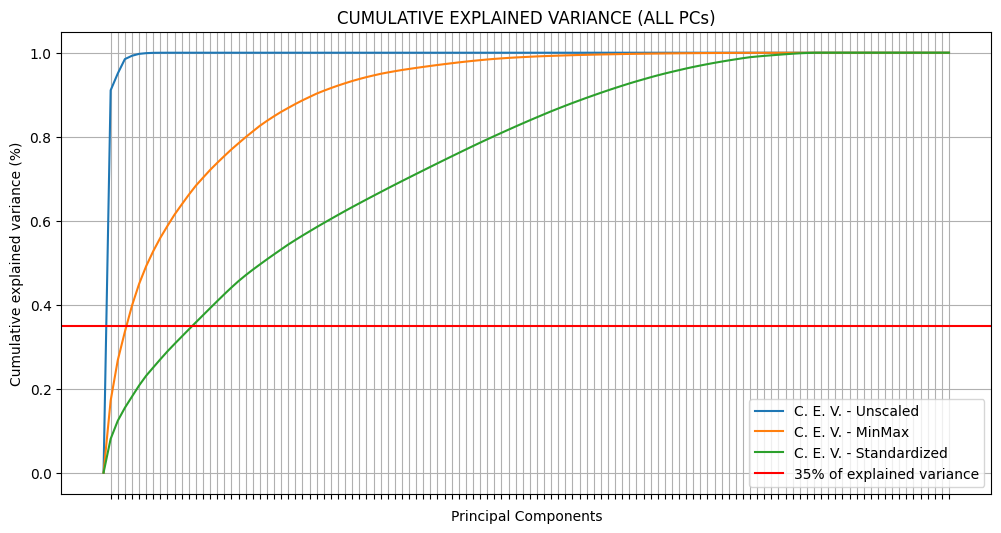

In [5]:
# INITIALIZE THE PCAs and FIT
pca_base = PCA(random_state = rs)
pca_base.fit(Xworkdf)
pca_std = PCA(random_state = rs)
pca_std.fit(Xworkdf_std)
pca_mm = PCA(random_state = rs)
pca_mm.fit(Xworkdf_mm)


# MAKE THE CUMULATIVE EXPLAINED VARIANCE PLOT
plt.figure(figsize = (12, 6))
cumvar_base = np.cumsum(pca_base.explained_variance_ratio_)
cumvar_mm = np.cumsum(pca_mm.explained_variance_ratio_)
cumvar_std = np.cumsum(pca_std.explained_variance_ratio_)
plt.plot(np.insert(cumvar_base, 0, 0), label = "C. E. V. - Unscaled")
plt.plot(np.insert(cumvar_mm, 0, 0), label = "C. E. V. - MinMax")
plt.plot(np.insert(cumvar_std, 0, 0), label = "C. E. V. - Standardized")
plt.axhline(y = 0.35, color = 'red', linestyle = '-', 
            label = "35% of explained variance")
plt.legend()
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs)')
plt.xticks(ticks = np.arange(1, pca_base.n_features_ + 1), labels = [])
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()

PCA behaves differently on the three dataset. On the non scaled data, more than 90\% of the variance is captured by the first component alone. This is not a surprise, and it is caused by the presence of different magnitude values in the various numeric features. On the other hand, the use of the standard scaler seems to be too harsh in terms of preserving information.

## Dimensionality Reduction and Interpretation of the PCs

The goal of this report is to identify meaningful profiles of the vehicles in a easily-comprehensible way. 

Specifically, at least 35% of the information have to be preserved, while using at most m=5 principal components

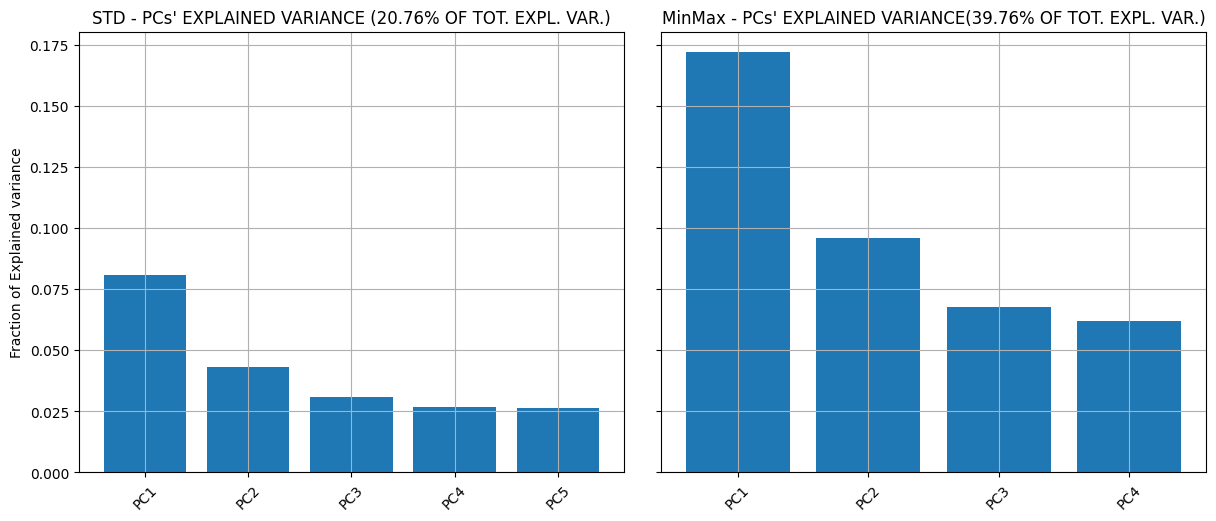

In [6]:
m = 5
perc = 0.35
m_mm = min(m, (1 + np.argmax([min(perc,v) for v in cumvar_mm])))
m_std = min(m, (1 + np.argmax([min(perc,v) for v in cumvar_std])))

# INITIALIZE THE PCAs and FIT
pca_std = PCA(random_state = rs, n_components = m_std)
pca_std.fit(Xworkdf_std)
pca_mm = PCA(random_state = rs, n_components = m_mm)
pca_mm.fit(Xworkdf_mm)


# COMPUTE THE PERCENTAGE OF TOT. EXPL. VARIANCE (ROUNDED TO 2 DECIMALS)
round_expl_var_ratio_std = np.round(pca_std.explained_variance_ratio_.sum() * 100, 
                                    decimals = 2)
round_expl_var_ratio_mm = np.round(pca_mm.explained_variance_ratio_.sum() * 100, 
                                   decimals = 2)

# MAKE THE BARPLOTS
fig, (ax_bar_std, ax_bar_mm) = plt.subplots(1, 2, figsize = (12,5), sharey = True)
fig.tight_layout()
ax_bar_std.bar(range(1, m_std + 1), pca_std.explained_variance_ratio_)
ax_bar_std.set_title("STD - PCs' EXPLAINED VARIANCE" + 
                     f" ({round_expl_var_ratio_std}% OF TOT. EXPL. VAR.)")
ax_bar_std.set_xticks(ticks = np.arange(1, m_std + 1), 
           labels = [f'PC{i}' for i in range(1, m_std + 1)],
           rotation = 45)
ax_bar_std.set_ylabel('Fraction of Explained variance')
ax_bar_std.grid()

ax_bar_mm.bar(range(1, m_mm + 1), pca_mm.explained_variance_ratio_)
ax_bar_mm.set_title("MinMax - PCs' EXPLAINED VARIANCE" +
                    f"({round_expl_var_ratio_mm}% OF TOT. EXPL. VAR.)")
ax_bar_mm.set_xticks(ticks = np.arange(1, m_mm + 1), 
           labels = [f'PC{i}' for i in range(1, m_mm + 1)],
           rotation = 45)
ax_bar_mm.grid()

In order to comprehend what each principal component is representing, a plot of them over each feature is required.

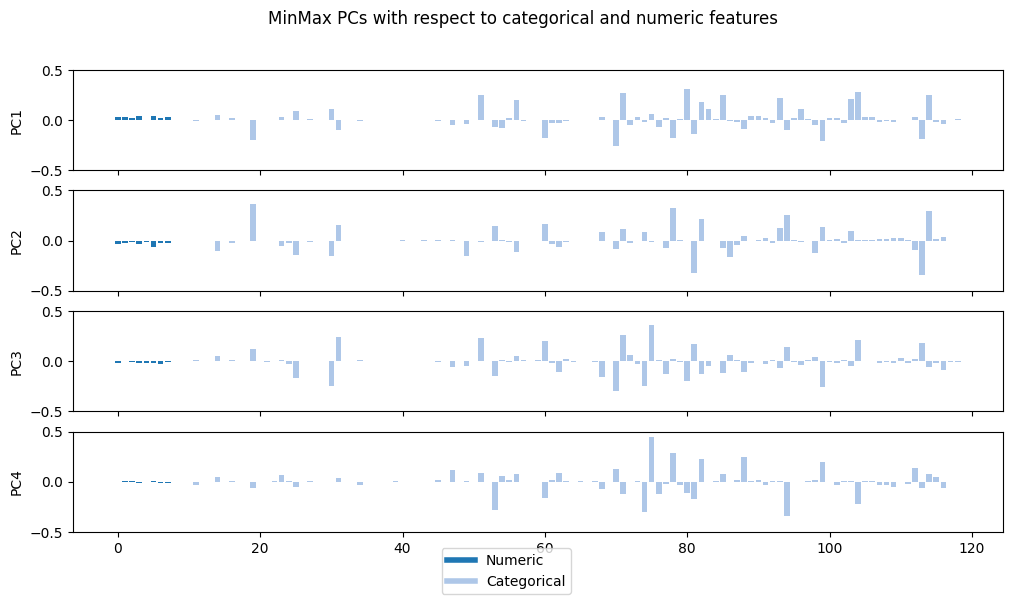

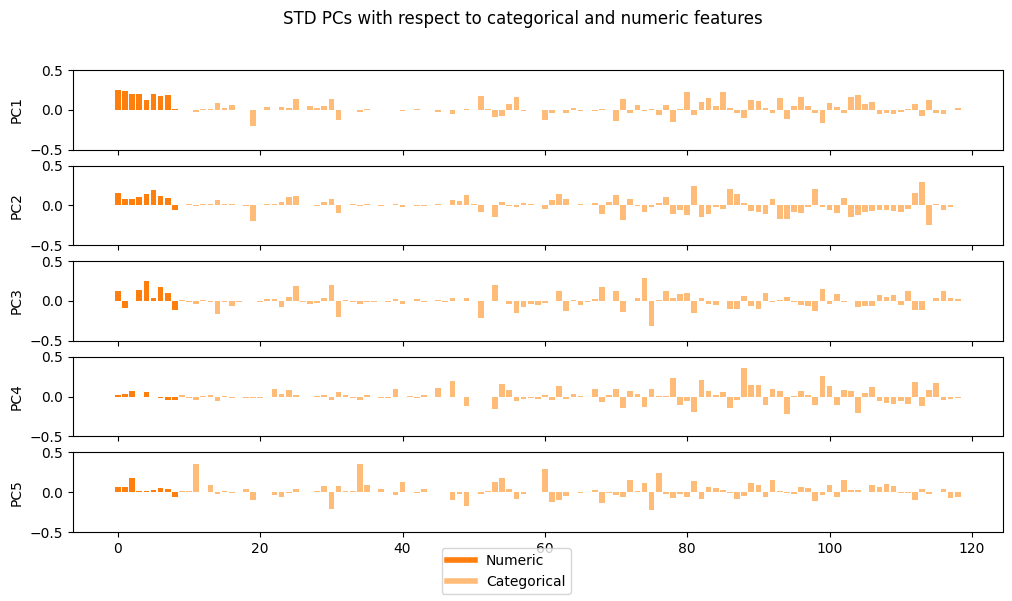

In [7]:
fig_mm, ax_mm = plt.subplots(m_mm, 1, sharey = True, sharex = True, 
                             figsize = (12, 6))
colors = cm.tab20.colors
ylim = [-0.5, 0.5]
for i in range(0, m_mm):
    ax_mm[i].bar(np.arange(pca_mm.n_features_), pca_mm.components_[i, :], 
                 color = [colors[0] if col in numeric_features 
                          else colors[1] for col in Xworkdf_mm.columns])
    ax_mm[i].grid = True
    ax_mm[i].set_ylim(ylim)
    ax_mm[i].set_ylabel(f'PC{i+1}')
custom_lines = [Line2D([0], [0], color = colors[0], lw = 4),
                Line2D([0], [0], color = colors[1], lw = 4)]
fig_mm.legend(custom_lines, ['Numeric', 'Categorical'], loc = 'lower center')
fig_mm.suptitle("MinMax PCs with respect to categorical and numeric features")



fig_std, ax_std = plt.subplots(m_std, 1, sharey = True, 
                               sharex = True, figsize = (12, 6))
colors = cm.tab20.colors
for i in range(0, m_std):
    ax_std[i].bar(np.arange(pca_std.n_features_), pca_std.components_[i, :], 
                  color = [colors[2] if col in numeric_features 
                           else colors[3] for col in Xworkdf_std.columns])
    ax_std[i].grid = True
    ax_std[i].set_ylim(ylim)
    ax_std[i].set_ylabel(f'PC{i+1}')
custom_lines = [Line2D([0], [0], color = colors[2], lw = 4),
                Line2D([0], [0], color = colors[3], lw = 4)]
fig_std.suptitle("STD PCs with respect to categorical and numeric features")
fig_std.legend(custom_lines, ['Numeric', 'Categorical'], loc = 'lower center')
print()

It is clear that only in the standardized PCs numeric features are taken into consideration. That is caused by the small variances of them relatively to the variances of categorical features obtained using the MinMax scaler.

PCs using both scaler are not easily understandable. In order to better understand them, let's highlight the biggest components of each of them.

### MinMax - Principal Components descriptions ###


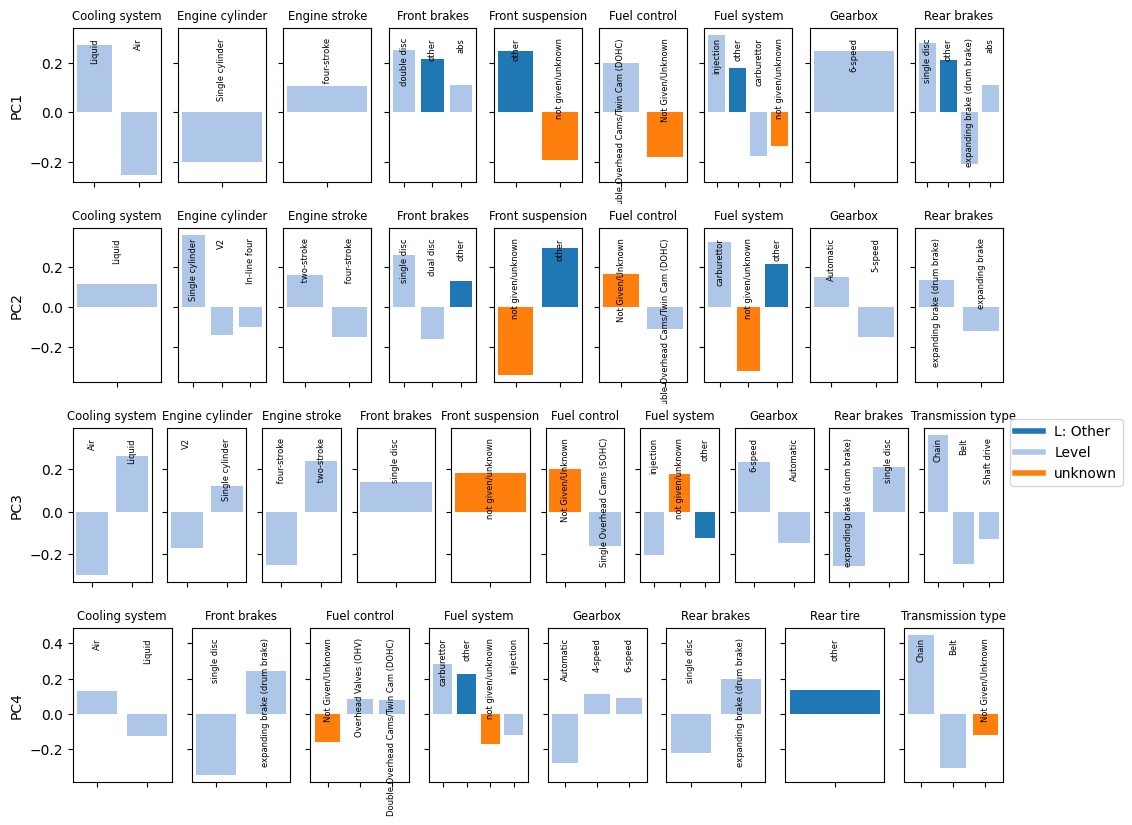

In [8]:
import warnings
warnings.filterwarnings("ignore")
# MinMax
cols = Xworkdf.columns
max_v = 20

colors = cm.tab20.colors
    
fig_mm = plt.figure(figsize = (12,8))
print("### MinMax - Principal Components descriptions ###")
subfigs_mm = fig_mm.subfigures(m_mm, 1)

for i, subfig in enumerate(subfigs_mm.flat):
    curr_pc = pd.Series(pca_mm.components_[i, :], index = cols)
    curr_biggest = curr_pc[curr_pc.abs().nlargest(max_v).index]
    curr_biggest.name = "component"
    df_curr_biggest = curr_biggest.to_frame().reset_index()
    df_curr_biggest.rename(columns = {"index":"f"}, inplace = True)
    df_curr_biggest[['feature', 'level']] = (
        df_curr_biggest.f.str.split(' - ', expand = True))
    df_curr_biggest["level"].fillna("value", inplace = True)
    df_curr_biggest.drop("f", axis = 1, inplace = True)
    # display(df_curr_biggest)
    unique_features = df_curr_biggest['feature'].drop_duplicates().sort_values()
    curr_features = unique_features.reset_index().drop("index", axis = 1)
    l_f = curr_features.size
    axs = subfig.subplots(1, l_f, sharex = False, sharey = True)
    for i_f, ax in enumerate(axs.flat):
        ax.clear()
        if i_f == 0:
            ax.set_ylabel(f'PC{i+1}')
        curr_f = curr_features['feature'][i_f]
        curr_levels = df_curr_biggest[df_curr_biggest['feature'] == curr_f]
        # display(curr_levels)
        ax.set_title(f'{curr_f}', fontsize = 'small')
        ax.bar(curr_levels["level"], curr_levels["component"], 
               color=[colors[2] 
                      if curr in ["not given/unknown","Not Given/Unknown"] 
                      else colors[0] if curr in ["other"] 
                      else colors[1] for curr in curr_levels["level"]])
        #ax.set_xticks([])
        ax.set_xticklabels(curr_levels["level"], y=1, rotation = 90, fontsize = 6)
        
custom_lines = [Line2D([0], [0], color = colors[0], lw = 4),
                Line2D([0], [0], color = colors[1], lw = 4),
                Line2D([0], [0], color = colors[2], lw = 4)]
plt.legend(custom_lines, ['L: Other', 'Level', 'unknown'], 
           loc = "upper left", bbox_to_anchor = (1, 2.4))
plt.show()

At first glance, it is possible to see that each PCs biggest absolute values come from the same features.

For clarity, the principal characterics of them may be summarized in:
* **(+)Liquid_6-speed - (-)Air_Expanding-brakes**
* **(+)Single-cylinder_Automatic - (-)5-speed**
* **(+)Liquid_Two-strokes_Chain - (-)Air_Four-strokes**
* **(+)Even-speed_Chain - (-) Automatic_Belt-unknown**

We also note that in the graph above, most features are common between the PCs, that indicates that those features are characterizing the motorvehicles.

### STD - Principal Components descriptions ###


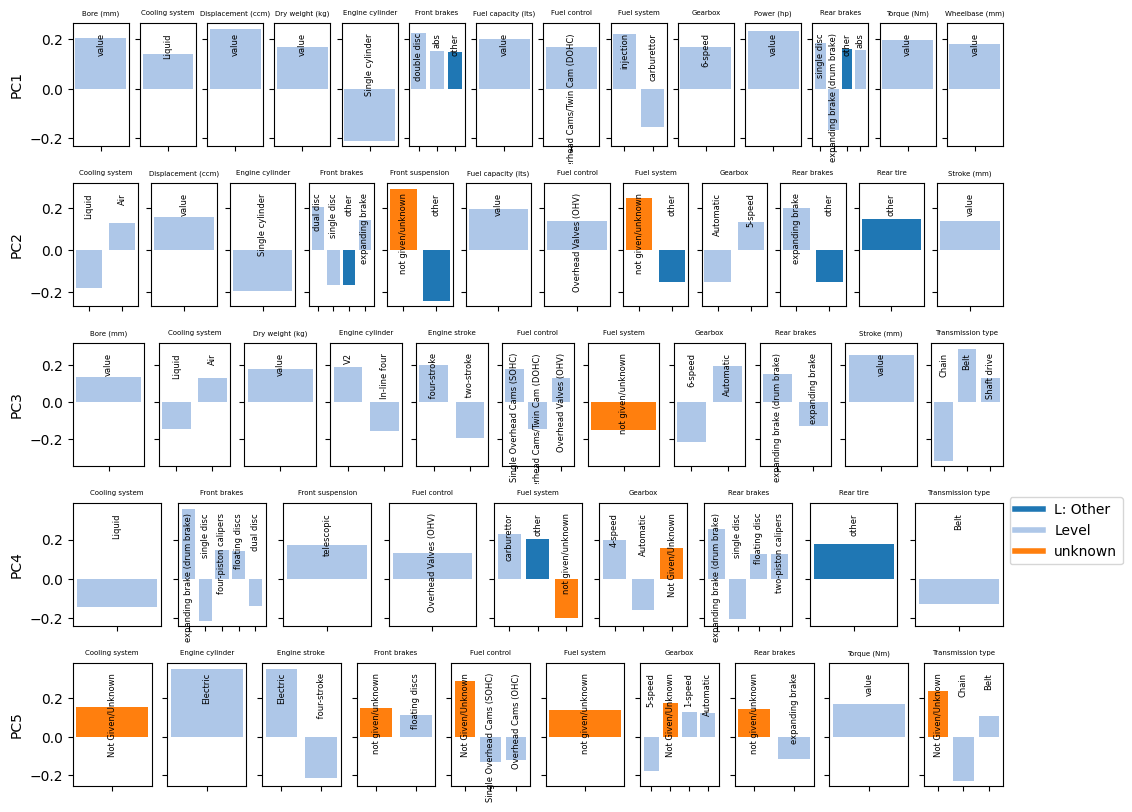

In [9]:
# STD
cols = Xworkdf.columns
max_v = 20

colors = cm.tab20.colors
    
fig_std = plt.figure(figsize = (12,8))
print("### STD - Principal Components descriptions ###")
subfigs_std = fig_std.subfigures(m_std, 1)

for i, subfig in enumerate(subfigs_std.flat):
    curr_pc = pd.Series(pca_std.components_[i, :], index = cols)
    curr_biggest = curr_pc[curr_pc.abs().nlargest(max_v).index]
    curr_biggest.name = "component"
    df_curr_biggest = curr_biggest.to_frame().reset_index()
    df_curr_biggest.rename(columns = {"index":"f"}, inplace = True)
    df_curr_biggest[['feature', 'level']] = (
        df_curr_biggest.f.str.split(' - ', expand = True))
    df_curr_biggest["level"].fillna("value", inplace = True)
    df_curr_biggest.drop("f", axis = 1, inplace = True)
    # display(df_curr_biggest)
    unique_features = df_curr_biggest['feature'].drop_duplicates().sort_values()
    curr_features = unique_features.reset_index().drop("index", axis = 1)
    l_f = curr_features.size
    axs = subfig.subplots(1, l_f, sharex = False, sharey = True)
    for i_f, ax in enumerate(axs.flat):
        ax.clear()
        if i_f == 0:
            ax.set_ylabel(f'PC{i+1}')
        curr_f = curr_features['feature'][i_f]
        curr_levels = df_curr_biggest[df_curr_biggest['feature'] == curr_f]
        ax.set_title(f'{curr_f}', fontsize = 5)
        ax.bar(curr_levels["level"], curr_levels["component"], 
               color = [colors[2] 
                        if curr in ["not given/unknown","Not Given/Unknown"] 
                        else colors[0] if curr in ["other"] 
                        else colors[1] for curr in curr_levels["level"]])
        #ax.set_xticks([])
        ax.set_xticklabels(curr_levels["level"], y=1, rotation = 90, fontsize = 6)
custom_lines = [Line2D([0], [0], color = colors[0], lw = 4),
                Line2D([0], [0], color = colors[1], lw = 4),
                Line2D([0], [0], color = colors[2], lw = 4)]
plt.legend(custom_lines, ['L: Other', 'Level', 'unknown'], 
           loc = "upper left", bbox_to_anchor = (1, 2.4))
plt.show()

The PCs obtained from the Standard scaler take into consideration numeric variables.
For clarity, the principal characterics of them may be summarized in:
* **Specifations**
* **(+)5-speed_Air - (-)Automatic_Liquid**
* **(+)V2_Four-stroke - (-)In-line-four_Two-strokes**
* **(+)Telescopic-suspensions - (-)Single/dual-disc**
* **(+)Electric**

#### Score Graphs

The way the PCs discriminate the data is now analyzed with the use of score graphs. From the set of label, "Brand" and "Model" and "Category" are categorical, and they have too many levels to have all of them be represented. Only the most common leveles will have their own color, the others will be grouped.

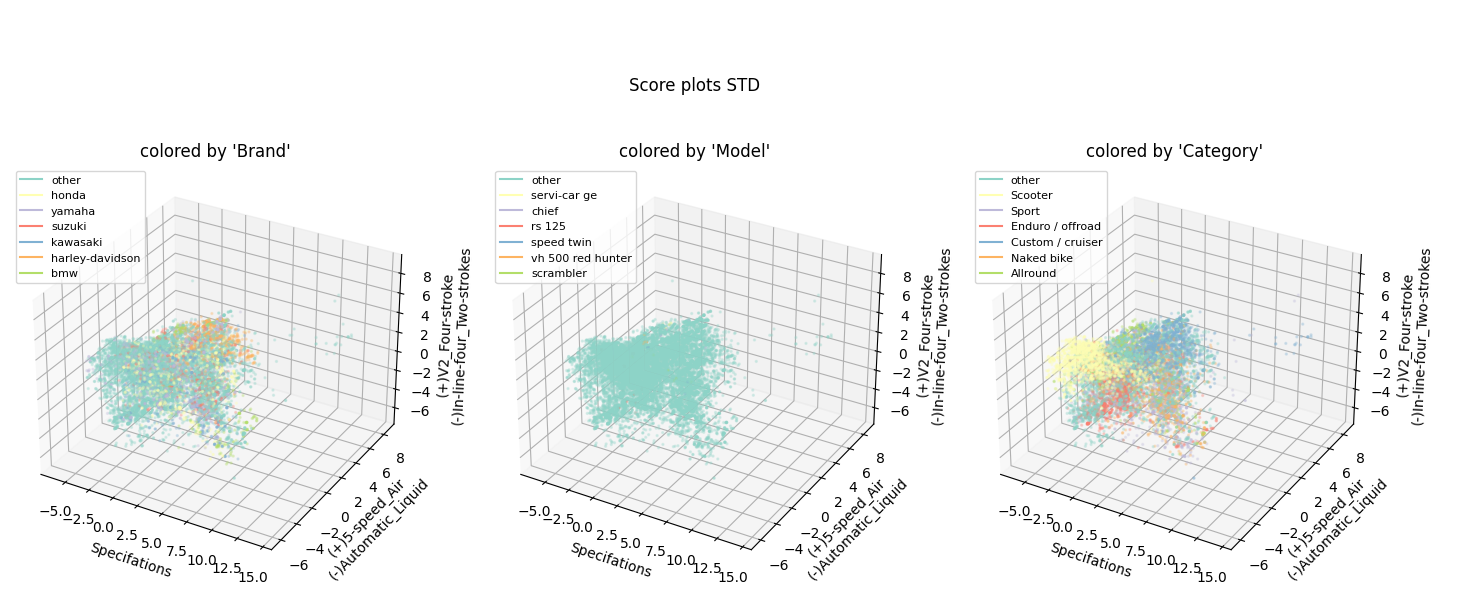

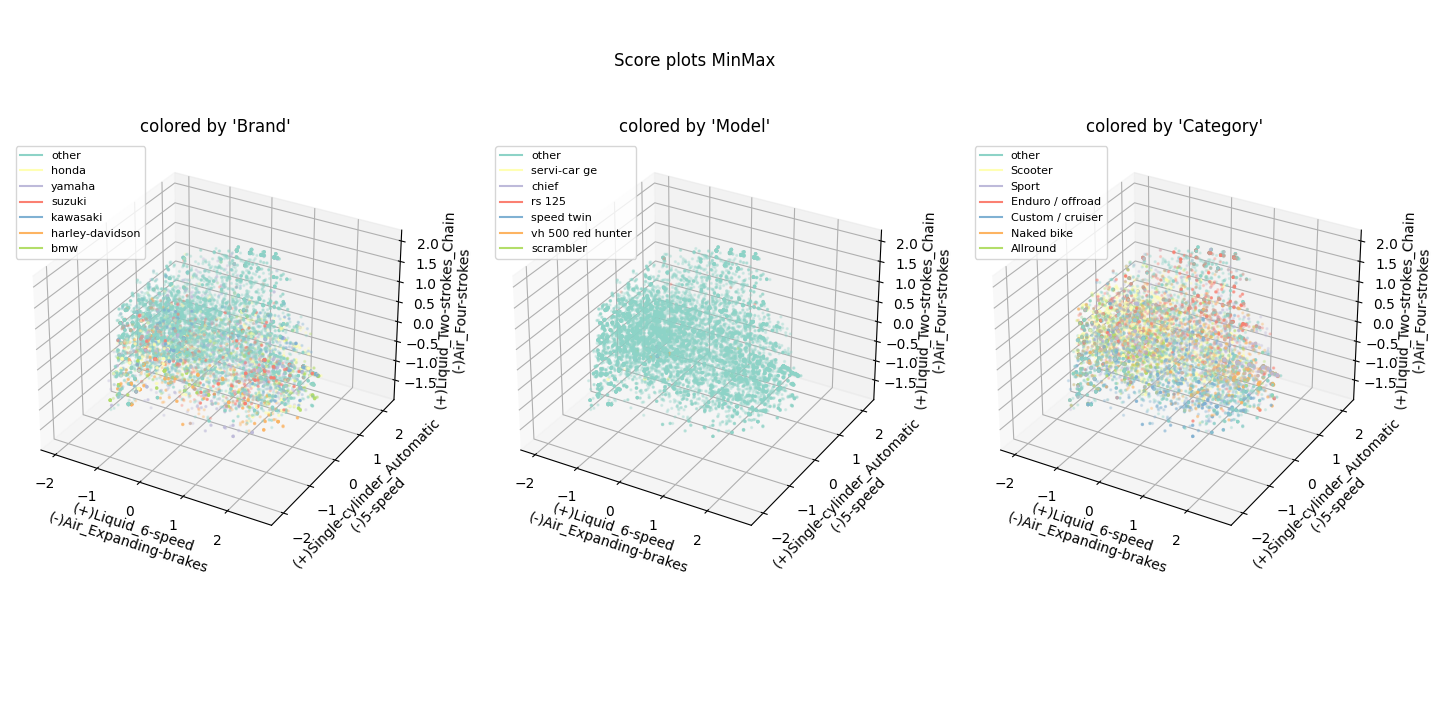

In [10]:
colorset = cm.Set3.colors
max_lev = 6
pc_names_std = ["Specifations",
                "(+)5-speed_Air\n(-)Automatic_Liquid",
                "(+)V2_Four-stroke\n(-)In-line-four_Two-strokes",
                "(+)Telescopic-suspensions\n (-)Single/dual-disc",
                "(+)Electric"]

fig_std, ax = plt.subplots(1, 3, figsize = (14, 7), 
                           subplot_kw = dict(projection = '3d'))
fig_std.tight_layout(w_pad = 5)
fig_std.suptitle('\n\nScore plots STD')
fig_std.text(1,1, "              ") #needed to show the z axis correctly
Ydata_std = pca_std.transform(Xworkdf_std)

cat_labels = [labels[index] for index in (0, 1, 3)]
for i_l, ax in enumerate(fig_std.get_axes()):
    curr_label = cat_labels[i_l]
    frequency = workdf[curr_label].value_counts()
    curr_levels = frequency.nlargest(max_lev).index.tolist()
    curr_levels.insert(0, "other")
    label_colors = {curr_levels[i]: colorset[i] for i in range(len(curr_levels))}
    curr_colors = [label_colors[t] 
                   if t in curr_levels 
                   else label_colors["other"] for t in workdf[curr_label].values]
    # legend
    colors_legend = [Line2D([0], [0], 
                            color = label_colors[k]) for k in label_colors.keys()]
    # MAKE THE 3D SCORE GRAPH
    ax.scatter(Ydata_std[:, 0], Ydata_std[:, 1], Ydata_std[:, 2], 
               s = 2, c = curr_colors, alpha = 0.25)
    ax.set_xlabel(pc_names_std[0])
    ax.set_ylabel(pc_names_std[1])
    ax.set_zlabel(pc_names_std[2])
    ax.legend(colors_legend, [k for k in label_colors.keys()], 
              loc = "upper left", fontsize = 8)
    ax.set_title(f"colored by '{curr_label}'")

pc_names_mm = ["(+)Liquid_6-speed\n(-)Air_Expanding-brakes", 
               "(+)Single-cylinder_Automatic\n(-)5-speed", 
               "(+)Liquid_Two-strokes_Chain\n(-)Air_Four-strokes", 
               "(+)Even-speed_Chain\n(-) Automatic_Belt-unknown"]
fig_mm, ax = plt.subplots(1, 3, figsize = (14, 7), 
                          subplot_kw = dict(projection = '3d'))
fig_mm.tight_layout(w_pad = 5)
fig_mm.suptitle('\n\nScore plots MinMax')
fig_mm.text(1,0, "        ") #needed to show the z axis correctly
Ydata_mm = pca_mm.transform(Xworkdf_mm)

cat_labels = [labels[index] for index in (0,1,3)]
for i_l, ax in enumerate(fig_mm.get_axes()):
    curr_label = cat_labels[i_l]
    # curr_levels = workdf[curr_label].unique()
    frequency = workdf[curr_label].value_counts()
    curr_levels = frequency.nlargest(max_lev).index.tolist()
    curr_levels.insert(0, "other")
    label_colors = {curr_levels[i]: colorset[i] for i in range(len(curr_levels))}
    curr_colors = [label_colors[t] 
                   if t in curr_levels 
                   else label_colors["other"] for t in workdf[curr_label].values]
    # legend
    colors_legend = [Line2D([0], [0], 
                            color = label_colors[k]) for k in label_colors.keys()]
    
    # MAKE THE 3D SCORE GRAPH
    ax.scatter(Ydata_mm[:, 0], Ydata_mm[:, 1], Ydata_mm[:, 2], 
               s = 2, c = curr_colors, alpha = 0.25)
    ax.set_xlabel(pc_names_mm[0])
    ax.set_ylabel(pc_names_mm[1])
    ax.set_zlabel(pc_names_mm[2])
    ax.legend(colors_legend, [k for k in label_colors.keys()], 
              loc = "upper left", fontsize = 8)
    ax.set_title(f"colored by '{curr_label}'")

No information can be extracted about the single models of the motorcycles. That is due to the granularity of the feature.

Regarding "Brand", it is common knowledge that almost every brand builds different kinds of vehicles, so guessing the brand cannot be done with only a characteristics ans specifics-driven analysis. A brand, _"harley-davidson"_, stand out for being compact in both the PC-spaces. That is caused by the brand long history of producing a very particular kind of motorcycle, instead of diversifying the products.

The "Category" is the label that the models differentiate better. Each one of the different categories seems to belong to a specific region of the 3D spaces in which it is plotted. That comes from different necessities of the different kind of motors: a "scooter" does not need the versatility of a 6-speed gearbox, but an "enduro" may do.

## k-Means

Now, a cluster analysis of the motorcycles in the PC-space is performed. Using the silhouette coefficient, it is possible to identify the best number of clustes. Regarding k-Means parameters, no one seems to have an impact on the results, but *n_init*.

In [11]:
# INITIALIZE SOME LISTS TO STORE THE TEMPORARY RESULTS AND, THEN, MAKE COMPARISONS
n_rounds = 20
km_list = []
silcoeff_list = []
k_list = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list)):
    km_list.append(KMeans(n_clusters = k_list[i], 
                          n_init = n_rounds, random_state = rs))
    km = km_list[i]
    km.fit(Ydata_std)
    silcoeff_list.append(silhouette_score(Ydata_std, km.labels_))

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best = np.argmax(silcoeff_list)
k_std = k_list[i_best]
km_std = km_list[i_best]
sil_k_std = np.max(silcoeff_list)
# VISUALIZE THE RESULT
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE FOR STD PC SPACE: {sil_k_std} --> k = {k_std}')
print('**************************************************************')

print('')
print('')
print('')
print('')

# INITIALIZE SOME LISTS TO STORE THE TEMPORARY RESULTS AND, THEN, MAKE COMPARISONS
km_list = []
silcoeff_list = []
k_list = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list)):
    km_list.append(KMeans(n_clusters = k_list[i], 
                          n_init = n_rounds, random_state = rs))
    km = km_list[i]
    km.fit(Ydata_mm)
    silcoeff_list.append(silhouette_score(Ydata_mm, km.labels_))


# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best = np.argmax(silcoeff_list)
k_mm = k_list[i_best]
km_mm = km_list[i_best]
sil_k_mm = np.max(silcoeff_list)
# VISUALIZE THE RESULT
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE FOR MM PC SPACE: {sil_k_mm} --> k = {k_mm}')
print('**************************************************************')

****************** RESULTS OF THE SEARCH... ******************
BEST SILHOUETTE SCORE FOR STD PC SPACE: 0.28052621264694416 --> k = 7
**************************************************************




****************** RESULTS OF THE SEARCH... ******************
BEST SILHOUETTE SCORE FOR MM PC SPACE: 0.33114871312837474 --> k = 5
**************************************************************


## Clusters and Centroids Interpretation and Visualization

In this section, the focus is on the centroids, and what belonging to a particular cluster means.

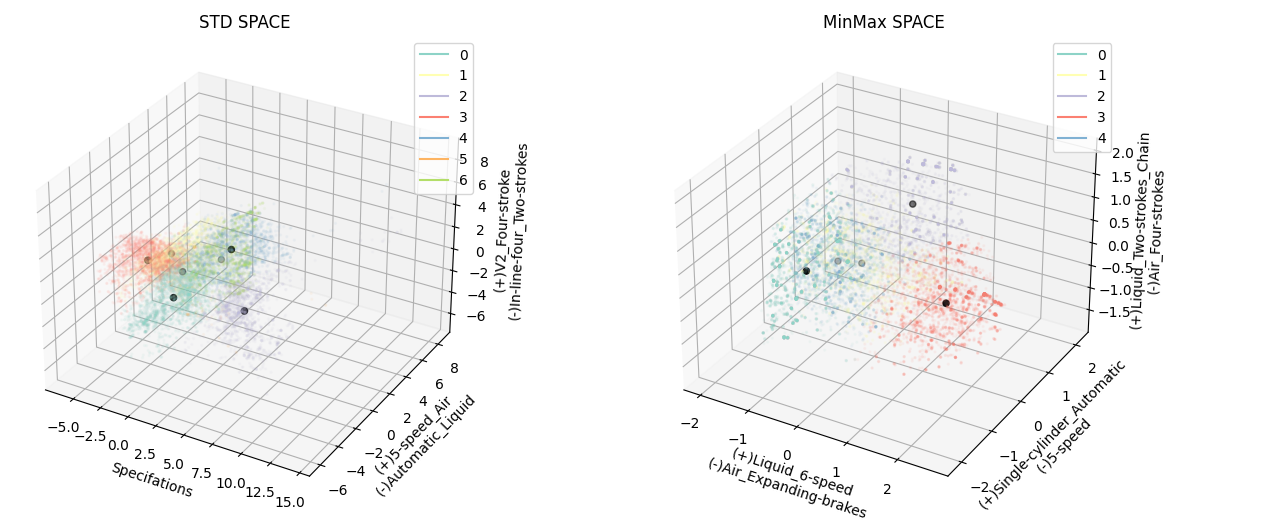

In [12]:
# EVALUATING COLORS
colorset = cm.Set3.colors
c_colors = {i: colorset[i] for i in range(k_std)}
cluster_colors_std = [c_colors[t] for t in km_std.labels_]
# legend
colors_legend = [Line2D([0], [0], color = c_colors[k]) for k in c_colors.keys()]
    
fig, (ax_sg_3d_km_std, ax_sg_3d_km_mm) = (
    plt.subplots(1, 2, figsize = (14, 5), subplot_kw = dict(projection = '3d')))
fig.tight_layout()
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS
ax_sg_3d_km_std.scatter(Ydata_std[:, 0], Ydata_std[:, 1], Ydata_std[:, 2], 
                        s = 2, c = cluster_colors_std, alpha = 0.05)
ax_sg_3d_km_std.scatter(km_std.cluster_centers_[:, 0], 
                        km_std.cluster_centers_[:, 1], 
                        km_std.cluster_centers_[:, 2], c = 'black')
#fig.suptitle('MOTROCYCLES - SCORE GRAPH')
ax_sg_3d_km_std.set_xlabel(pc_names_std[0])
ax_sg_3d_km_std.set_ylabel(pc_names_std[1])
ax_sg_3d_km_std.set_zlabel(pc_names_std[2])
ax_sg_3d_km_std.set_title("STD SPACE")
ax_sg_3d_km_std.legend(colors_legend, [k for k in c_colors.keys()])



c_colors = {i: colorset[i] for i in range(k_mm)}
cluster_colors_mm = [c_colors[t] for t in km_mm.labels_]
# legend
colors_legend = [Line2D([0], [0], color = c_colors[k]) for k in c_colors.keys()]

ax_sg_3d_km_mm.scatter(Ydata_mm[:, 0], Ydata_mm[:, 1], Ydata_mm[:, 2], 
                       s = 2, c = cluster_colors_mm, alpha = 0.05)
ax_sg_3d_km_mm.scatter(km_mm.cluster_centers_[:, 0], 
                       km_mm.cluster_centers_[:, 1], 
                       km_mm.cluster_centers_[:, 2], c = 'black')
ax_sg_3d_km_mm.set_xlabel(pc_names_mm[0])
ax_sg_3d_km_mm.set_ylabel(pc_names_mm[1])
ax_sg_3d_km_mm.set_zlabel(pc_names_mm[2])
ax_sg_3d_km_mm.set_title("MinMax SPACE")
ax_sg_3d_km_mm.legend(colors_legend, [k for k in c_colors.keys()])
#(x0, y0, width, height) = ax_sg_3d_km_mm.get_position().bounds
#new_pos = Bbox.from_bounds(x0-0.1, y0, width+0.5, height)
#ax_sg_3d_km_mm.set_position(new_pos)
fig.text(1, 1, " ") #needed to show the z axis correctly
plt.grid()
plt.show()

Moreover, let's see the centroids components, and the projections of each cluster onto the PCs.

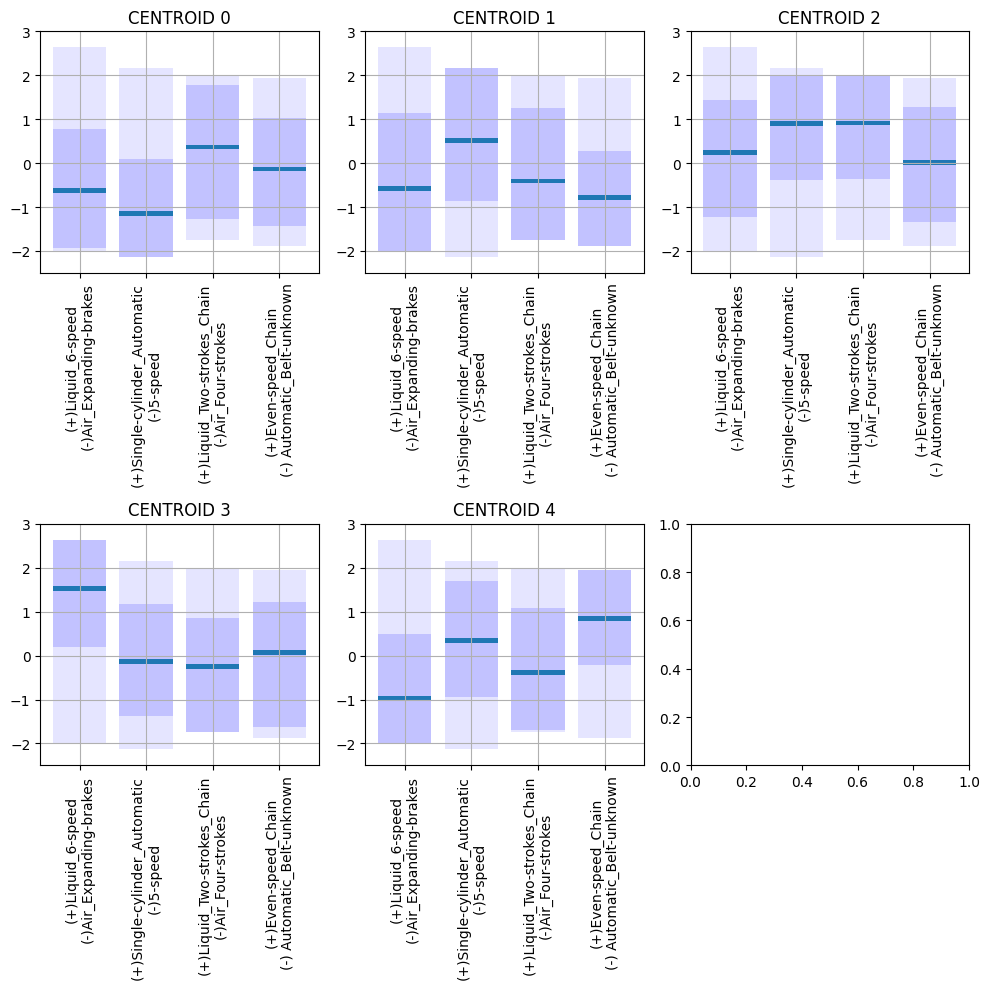

In [13]:
#MinMax

# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Ydata_mm.max(axis=0) 
mins_y = Ydata_mm.min(axis=0) 
thickness = 0.02

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids_mm, ax_centroids_mm = plt.subplots(2, 3, figsize = (10, 10))
for id_ax, ax in enumerate(fig_centroids_mm.get_axes()):
    if id_ax == 5:
        break
    ax.bar(np.arange(km_mm.cluster_centers_.shape[1]), height = maxs_y - mins_y, 
           bottom = mins_y, color = 'blue', alpha = 0.1)
    curr_min = Ydata_mm[km_mm.labels_ == id_ax].max(axis = 0) 
    curr_max = Ydata_mm[km_mm.labels_ == id_ax].min(axis = 0) 
    ax.bar(np.arange(km_mm.cluster_centers_.shape[1]), 
           height = curr_max - curr_min, 
           bottom = curr_min, color = 'blue', alpha = 0.15)
    ax.bar(np.arange(km_mm.cluster_centers_.shape[1]), height = thickness*5.5, 
           bottom = km_mm.cluster_centers_[id_ax, :] - thickness/2*5.5)
    ax.set_xticks(ticks = np.arange(km_mm.cluster_centers_.shape[1]))
    ax.set_ylim([-2.5, 3])
    ax.set_xticklabels(labels = pc_names_mm, rotation = 90)
    ax.grid(visible = True, which = 'both')
    plt.tight_layout()
    ax.set_title(f'CENTROID {id_ax}')

The lighter ranges are the span of the values of the all database. The darker is the span for that cluster, and the line represent the value of the component for the controid.

We see that Centroid 3 is the only one in which big values of the first components are present. Centroid 4 is the only one with small values of the fourth component.

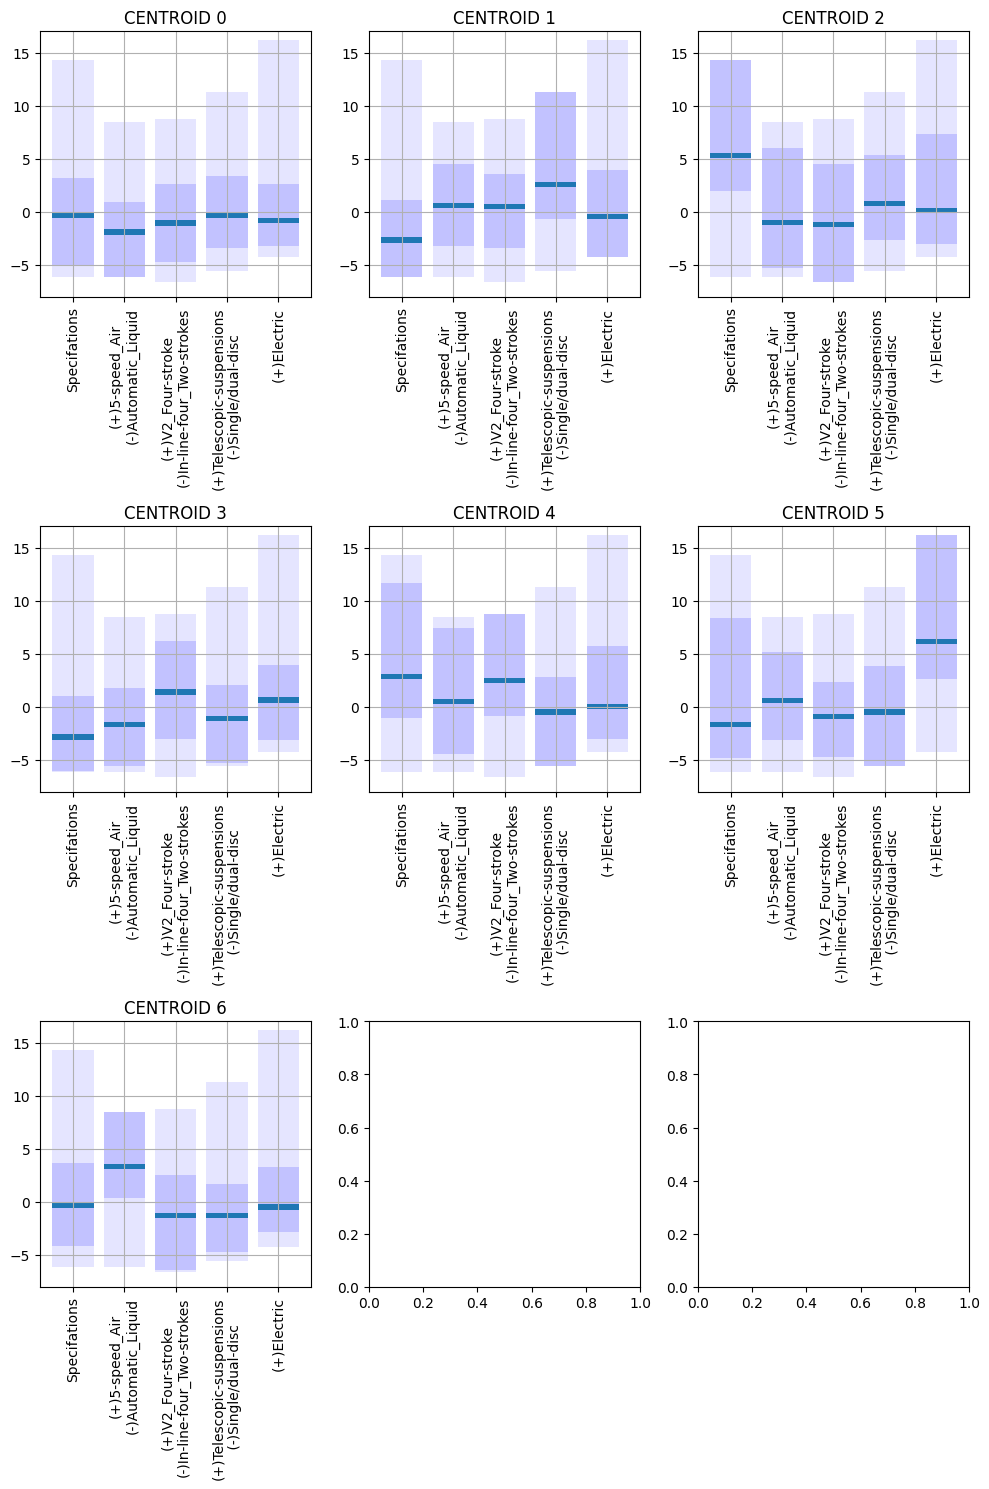

In [14]:
#STD

# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Ydata_std.max(axis=0) 
mins_y = Ydata_std.min(axis=0)

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids_std, ax_centroids_std = plt.subplots(3, 3, figsize = (10, 15))
for id_ax, ax in enumerate(fig_centroids_std.get_axes()):
    if id_ax == 7:
        break
    ax.bar(np.arange(km_std.cluster_centers_.shape[1]), height = maxs_y - mins_y, 
           bottom = mins_y, color = 'blue', alpha = 0.1)
    curr_min = Ydata_std[km_std.labels_ == id_ax].max(axis = 0) 
    curr_max = Ydata_std[km_std.labels_ == id_ax].min(axis = 0) 
    ax.bar(np.arange(km_std.cluster_centers_.shape[1]), 
           height = curr_max - curr_min, 
           bottom = curr_min, color = 'blue', alpha = 0.15)
    ax.bar(np.arange(km_std.cluster_centers_.shape[1]), height = thickness*25, 
           bottom = km_std.cluster_centers_[id_ax, :] - thickness/2*25)
    ax.set_xticks(ticks = np.arange(km_std.cluster_centers_.shape[1]))
    ax.set_ylim([-8, 17])
    ax.set_xticklabels(labels = pc_names_std, rotation = 90)
    ax.grid(visible = True, which = 'both')
    plt.tight_layout()
    ax.set_title(f'CENTROID {id_ax}')

We see that Cluster 1, 2 and 4 are the only presenting high values of _Telescopic-suspensions_, _Specifications_ and _V2_ components respectively.

These observations are not sufficient to give a proper name to each cluster. In order to do that,we will now perform clusters and centroids evaluation.

## Clusters and Centroids Evaluation

The proposed centroids have to be evaluated. It is possible to use an internal evaluation, using the silhouette coefficients calculated before. It is known that the silhouette coefficient takes values from -1 to 1 and it is a measure of how similar an object is to its own cluster compared to others. 

The silhouette coefficient obtained for the...
* ...Standard scaled clustering was about 0.281;
* ...MinMax scaled clustering was about 0.331.

Another way to evaluate the clusterings is to apply an external evaluation. The label under observation is "Category". Below, the tables sum up the percentage of each category in each cluster.

In [15]:
# MinMax
c_name = [f"Cluster {i}" for i in range(k_mm)]
ext_val_mm = pd.DataFrame(columns = c_name)
for cat in workdf["Category"].unique():
    curr_index = workdf[workdf["Category"] == cat].index
    curr_clusters = pd.Series([f"Cluster {i}" for i in km_mm.labels_[curr_index]])
    distribution = curr_clusters.value_counts(normalize = True)
    distribution.name = cat
    ext_val_mm = pd.concat([ext_val_mm, distribution.to_frame().T])
ext_val_mm["Sum"] = ext_val_mm.sum(axis = 1)
ext_val_mm["Count"] = [len(workdf[workdf["Category"] == cat].index) 
                       for cat in workdf["Category"].unique()]
ext_val_mm.fillna(0, inplace = True)
ext_val_mm = ext_val_mm.sort_index(axis=0)
print('### Distribution of the label "Category" using clustering on MinMax scaled data ###')
display(ext_val_mm)
print()
print()
# STD
c_name = [f"Cluster {i}" for i in range(k_std)]
ext_val_std = pd.DataFrame(columns = c_name)
for cat in workdf["Category"].unique():
    curr_index = workdf[workdf["Category"] == cat].index
    curr_clusters = pd.Series([f"Cluster {i}" for i in km_std.labels_[curr_index]])
    distribution = curr_clusters.value_counts(normalize = True)
    distribution.name = cat
    ext_val_std = pd.concat([ext_val_std, distribution.to_frame().T])
ext_val_std["Sum"] = ext_val_std.sum(axis = 1)
ext_val_std["Count"] = [len(workdf[workdf["Category"] == cat].index) 
                        for cat in workdf["Category"].unique()]
ext_val_std.fillna(0, inplace = True)
ext_val_std = ext_val_std.sort_index(axis=0)
display(ext_val_std[ext_val_std.columns[0:4]])
display(ext_val_std[ext_val_std.columns[4:9]])
# pd.set_option('display.max_columns', 12)
# display(ext_val_std)

### Distribution of the label "Category" using clustering on MinMax scaled data ###


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Sum,Count
ATV,0.029183,0.383268,0.058366,0.322957,0.206226,1.0,514
Allround,0.178309,0.061581,0.032169,0.154412,0.573529,1.0,1088
Classic,0.494334,0.048159,0.019830,0.257790,0.179887,1.0,706
Cross / motocross,0.103594,0.033827,0.613108,0.131078,0.118393,1.0,473
Custom / cruiser,0.269074,0.172343,0.034741,0.400545,0.123297,1.0,1468
Enduro / offroad,0.212003,0.038487,0.409002,0.146119,0.194390,1.0,1533
"Minibike, cross",0.187500,0.093750,0.375000,0.000000,0.343750,1.0,192
"Minibike, sport",0.093750,0.109375,0.468750,0.000000,0.328125,1.0,64
Naked bike,0.254609,0.052678,0.074627,0.516242,0.101844,1.0,1139
Prototype / concept model,0.328571,0.128571,0.085714,0.400000,0.057143,1.0,70


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
ATV,0.157588,0.171206,0.011673,0.192607
Allround,0.113051,0.558824,0.111213,0.068015
Classic,0.072238,0.143059,0.143059,0.028329
Cross / motocross,0.763214,0.122622,0.000000,0.035941
Custom / cruiser,0.051771,0.094005,0.060627,0.021117
Enduro / offroad,0.558382,0.141553,0.051533,0.033268
"Minibike, cross",0.286458,0.338542,0.000000,0.187500
"Minibike, sport",0.265625,0.343750,0.000000,0.312500
Naked bike,0.171203,0.069359,0.366989,0.032485
Prototype / concept model,0.142857,0.042857,0.214286,0.014286


,Cluster 4,Cluster 5,Cluster 6,Sum,Count
ATV,0.457198,0.000000,0.009728,1.0,514
Allround,0.022978,0.021140,0.104779,1.0,1088
Classic,0.138810,0.012748,0.461756,1.0,706
Cross / motocross,0.000000,0.021142,0.057082,1.0,473
Custom / cruiser,0.572888,0.011580,0.188011,1.0,1468
Enduro / offroad,0.019569,0.017613,0.178082,1.0,1533
"Minibike, cross",0.000000,0.145833,0.041667,1.0,192
"Minibike, sport",0.000000,0.031250,0.046875,1.0,64
Naked bike,0.110623,0.020193,0.229148,1.0,1139
Prototype / concept model,0.171429,0.285714,0.128571,1.0,70


In the end, it is possible to interprete the clusters as:

MinMax PC space:
* Cluster 0: Classic and sport turing
* Cluster 1: Scooter
* Cluster 2: Offroad
* Cluster 3: Naked bike and touring (or Liquid 6-speed)
* Cluster 4: Allround

STD PC space:
* Cluster 0: Offroad
* Cluster 1: Telescopic suspensions
* Cluster 2: Top Specs
* Cluster 3: Scooter
* Cluster 4: Bulky V2 vehicles
* Cluster 5: Electric
* Cluster 6: 5-speed, air vehicles

The centroid of each cluster may be then interpreted as a representant of that category/group of categories of motorcycles. Some catogories (such as "Scooter" in the MinMax scaler case) are distributed between different clusters. That is due to the different type of vehicles inside a given category (for example, a "Sport" motorcycle may range between an allround vehicle, a touring motorcycle and a naked bike).

It is clear that not all categories are identified by these clusters. However, that may be due to similarities between motorcycles extending throughout multiples categories:

* A category like "_sport_" is very broad, and a vehicle categorized as such may have different specifics and characteristics. It may range between an allround, a touring (so much that "_sport touring_" is a category on its own) and a naked bike, which are characterized by their own different clusters, causing "sport" to be very distributed.

* A category like "_trial_", despite being not frequent, is identified with high accuracy by both clustering methods, that is due to "_trial_" being a very atypical kind of motorcycle. These are clustered with minibikes, which are also really atypicall.

* Finally, a category like "_ATV_" lies in between, it has a specific scope, going offroad, but at the same time is quite atypical for that scope. These cause "ATV" to be mixed both with the offroad vehicles and the scooters.

## Conclusions

Principal component analysis on bikez.com was useful to identify what characterize a motorcycle (e.g. the gearbox, the type of cooling and the specific). Combining that with a clustering algorithm, it is possible to identify the scope of a motorcycle (offroad, city o long distance usage), which overlap with the category of the motorcycles.

In other words, different categories of motorcycles requires different characteristics, so by knowing the characteristic of a vehicle it is possible to infer its usage and derive a narrow range of categories that vehicle may belong to.